In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [3]:
# Change the data type of column 'A' from float64 to float32
df['amount'] = df['amount'].astype('float32')
df['oldbalanceOrg'] = df['oldbalanceOrg'].astype('float32')
df['oldbalanceDest'] = df['oldbalanceDest'].astype('float32')
df['newbalanceOrig'] = df['newbalanceOrig'].astype('float32')
df['newbalanceDest'] = df['newbalanceDest'].astype('float32')

In [4]:
df['step'] = df['step'].astype('int32')
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype('int32') 
df['isFraud'] = df['isFraud'].astype('int32') 

In [5]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['nameDest'])
# printing label
label
# removing the column 'type' from df
# as it is of no use now.
df.drop("nameDest", axis=1, inplace=True)
# Appending the array to our dataFrame
# with column name 'type'
df["nameDest"] = label
# printing Dataframe
#df

In [6]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['type'])
# printing label
label
# removing the column 'type' from df
# as it is of no use now.
df.drop("type", axis=1, inplace=True)
# Appending the array to our dataFrame
# with column name 'type'
df["type"] = label
# printing Dataframe
#df

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameOrig'])
label
df.drop("nameOrig", axis=1, inplace=True)
df["nameOrig"] = label
#df

## Split

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
# Separate the target variable
y = df['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=18)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.99871
1    0.00129
Name: isFraud, dtype: float64


## Class imbalance

In [9]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection

# Assume X_train and y_train are the original training data
# resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='auto')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train, y_train)

# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='auto')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [10]:
X_train_resampled_new.shape

(5718840, 10)

In [11]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_train)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 5718966
Class 1 count: 7392


In [12]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='auto')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [13]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_train_resampled_final)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 5425025
Class 1 count: 7392


In [14]:
X_train_resampled_final.shape

(5432417, 10)

In [15]:
import numpy as np

# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_test)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 635441
Class 1 count: 821


## Outliers

In [16]:
import random
import numpy as np
from scipy import stats

# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.14, 'oldbalanceOrg': 0.24, 'newbalanceOrig': 0.25, 'oldbalanceDest': 0.22, 'newbalanceDest': 0.22}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]

# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

Train set trimmed means:  {'amount': 89957.9728125, 'oldbalanceOrg': 18236.3167578125, 'newbalanceOrig': 13326.66779296875, 'oldbalanceDest': 218939.1209375, 'newbalanceDest': 278659.530625}


In [17]:
# Assuming your original training data is stored in a pandas DataFrame called X_train
# And assuming you have a list of selected feature names called selected_features
selected_features = ['oldbalanceOrg', 'type', 'nameDest','amount','step']
X_train_selected = X_train_resampled_final[selected_features]

In [18]:
X_train_selected

,oldbalanceOrg,type,nameDest,amount,step
0,12691.000000,3,681199,9169.459961,215
1,3296.000000,1,11427,305161.156250,373
2,0.000000,3,1743120,8840.879883,406
3,10548.000000,3,736364,3120.010010,205
4,0.000000,1,555402,89957.976562,301
...,...,...,...,...,...
5432412,18236.316406,1,429207,145982.359375,279
5432413,114889.609375,4,514301,114889.609375,227
5432414,18236.316406,4,58810,89957.976562,583
5432415,18236.316406,4,230091,89957.976562,98


In [19]:
X_test_selected=X_test[selected_features]

In [20]:
X_test_selected

,oldbalanceOrg,type,nameDest,amount,step
1402687,2.080000e+03,0,75898,176116.968750,139
2760752,5.854688e+06,0,119926,559868.187500,213
3594236,2.745168e+05,3,1249878,8622.099609,262
1933631,7.080094e+04,3,2423326,30724.619141,177
2227203,0.000000e+00,4,426875,815273.687500,186
...,...,...,...,...,...
3753638,0.000000e+00,3,2617210,1305.969971,279
1532557,1.235073e+06,3,1970706,26853.359375,154
2800777,1.291580e+04,3,2318385,28641.919922,217
2444235,2.710670e+05,3,1893170,10589.280273,203


In [21]:
from sklearn.ensemble import RandomForestClassifier
# Select top features using Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train_resampled_final)

RandomForestClassifier()

## Hyperparamter tuning

In [22]:
from scipy.stats import randint as sp_randint
# Define your hyperparameter search space
param_dist = { 
    'n_estimators': sp_randint(100, 250),
    'max_features': ['sqrt', 'log2'],
    'max_depth' : sp_randint(2,3),
    'criterion' :['gini', 'entropy'],
}

In [23]:
from sklearn.experimental import enable_halving_search_cv  # Required to enable HalvingRandomSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# Set up the HalvingRandomSearchCV with aggressive early stopping
search = HalvingRandomSearchCV(rf, param_dist, cv=5,verbose=1, 
                               factor=2, resource='n_samples', max_resources=100, 
                               aggressive_elimination=True, 
                               scoring='accuracy', refit=True)

# Fit the HalvingRandomSearchCV object to the data
search.fit(X_train_selected, y_train_resampled_final)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 100
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 1
n_candidates: 3
n_resources: 40
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 2
n_resources: 80
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingRandomSearchCV(aggressive_elimination=True,
                      estimator=RandomForestClassifier(), factor=2,
                      max_resources=100,
                      param_distributions={'criterion': ['gini', 'entropy'],
                                           'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000261834FD460>,
                                           'max_features': ['sqrt', 'log2'],
                                           'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002612BC6E910>},
                      scoring='accuracy', verbose=1)

In [24]:
# Get the best hyperparameters and evaluate on the test set
best_params = search.best_params_
best_model = search.best_estimator_

In [25]:
y_pred = best_model.predict(X_test_selected)

In [26]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Best hyperparameters:", best_params)
print("Test set accuracy:", accuracy)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 221}
Test set accuracy: 0.9987520864046572


## Model training

Fold: 1
Confusion matrix:
 [[2712513       0]
 [   3560     136]]
Recall: 0.0367965367965368
Precision: 1.0
F1-score: 0.0709812108559499
OOB error: 0.0013102825704069954
---------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2712513
           1       1.00      0.04      0.07      3696

    accuracy                           1.00   2716209
   macro avg       1.00      0.52      0.54   2716209
weighted avg       1.00      1.00      1.00   2716209

Fold: 2
Confusion matrix:
 [[2712508       4]
 [   3551     145]]
Recall: 0.03923160173160173
Precision: 0.9731543624161074
F1-score: 0.0754226267880364
OOB error: 0.0013128592092876978
---------------------
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2712512
           1       0.97      0.04      0.08      3696

    accuracy                           1.00   2716208
   macr

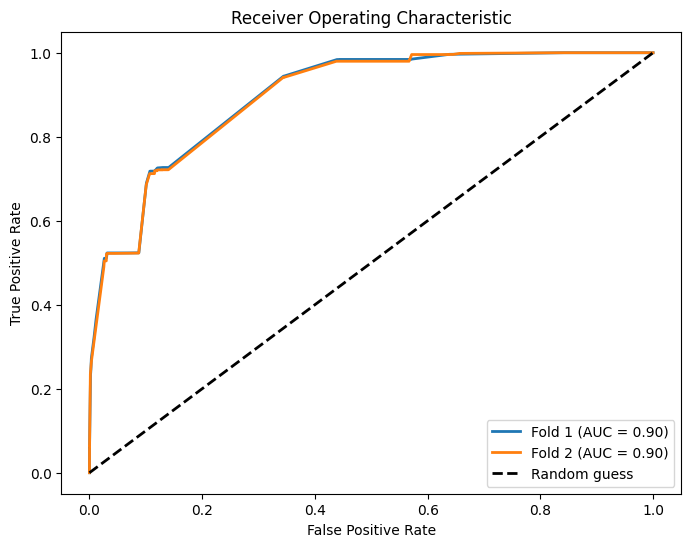

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import numpy as np
from sklearn.metrics import classification_report

# Define the number of splits for stratified cross-validation
n_splits = 2

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

# Create lists to store evaluation metrics for each fold
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []

# Create lists to store ROC curve data for each fold
fprs = []
tprs = []
aucs = []

# Initialize the OOB error list
oob_error = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_selected, y_train_resampled_final)):
    print(f'Fold: {fold+1}')
    
    # Split the data into training and validation sets
    X_fold_train, y_fold_train = X_train_selected.iloc[train_idx], y_train_resampled_final.iloc[train_idx]
    X_val, y_val = X_train_selected.iloc[val_idx], y_train_resampled_final.iloc[val_idx]


    # Create a RandomForestClassifier object with the given hyperparameters
    rf_model = RandomForestClassifier(criterion='gini', max_depth= 2, max_features='log2', n_estimators= 221,oob_score=True)
   
    # Fit the model on the training data
    rf_model.fit(X_fold_train, y_fold_train)

    # Predict the class labels for the validation set
    y_val_pred = rf_model.predict(X_val)
    
    # Predict the class probabilities for the validation set
    y_val_pred_proba = rf_model.predict_proba(X_val)

    # Set the threshold
    threshold = 0.225

    # Convert the probabilities to binary predictions based on the threshold
    y_val_pred = (y_val_pred_proba[:,1] > threshold).astype(int)

    # Compute the evaluation metrics for the current fold
    conf_mat = confusion_matrix(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Append the evaluation metrics for the current fold to the lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
    roc_auc = auc(fpr, tpr)
    
    # Append the ROC curve data for the current fold to the lists
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

    # Compute the OOB error for the current fold and append to the list
    oob_error.append(1 - rf_model.oob_score_)

    # Print the evaluation metrics for the current fold
    print('Confusion matrix:\n', conf_mat)
    print('Recall:', recall)
    #print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('F1-score:', f1)
    print('OOB error:', 1 - rf_model.oob_score_)
    print('---------------------')
    
    # Compute the classification report for the current fold
    report = classification_report(y_val, y_val_pred)

    # Print the classification report
    print('Classification report:\n', report)

# Create the ROC curve plot
fig, ax = plt.subplots(figsize=(8,6))

# Plot the ROC curve for each fold
for i in range(n_splits):
    ax.plot(fprs[i], tprs[i], lw=2, label='Fold %d (AUC = %0.2f)' % (i+1, aucs[i]))

# Add a dashed line representing the random guess classifier
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random guess')

# Add labels and legend to the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend()

In [30]:
print('Average Recall_scores:', sum(recall_scores)/len(recall_scores))
print('Average F1-score:', sum(f1_scores)/len(f1_scores))
print('Average Precision_scores:', sum(precision_scores)/len(precision_scores))
#print('Average Accuracy_scores:', sum(accuracy_scores)/len(accuracy_scores))

Average Recall_scores: 0.038014069264069264
Average F1-score: 0.07320191882199314
Average Precision_scores: 0.9865771812080537


## Choice 1- Learning curve

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013112027298346205],
 [0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.001247913595342799])

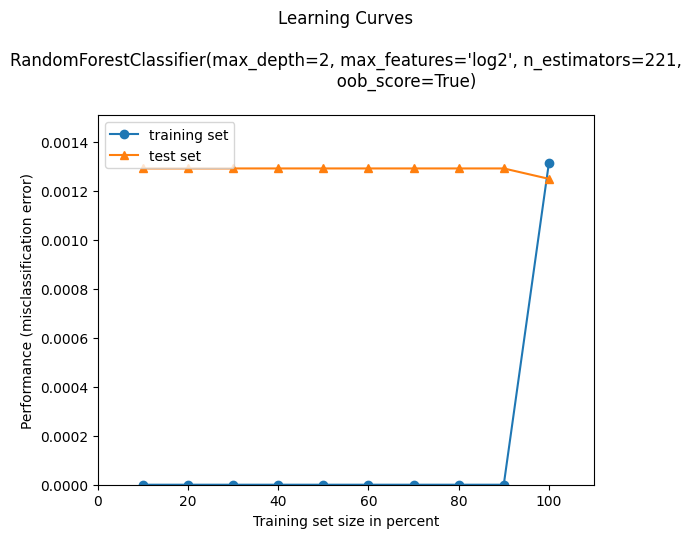

In [31]:
# Load the plot_learning_curves class
from mlxtend.plotting import plot_learning_curves
 
# Plot the learning curves
plot_learning_curves(X_train_selected, y_train_resampled_final, X_test_selected, y_test, rf_model)

## Choice 2- Learning Curve

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train_selected,
    "y": y_train_resampled_final,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Precision",
}

estimator = rf_model
LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

## Evaluate test- NEW

Instead, threshold moving can help to optimize the performance of the classifier on the imbalanced test set by adjusting the threshold used to assign the predicted probabilities to the class labels. By setting an appropriate threshold, we can improve the balance between precision and recall and reduce the impact of the class imbalance on the performance of the classifier.

## Confusion matrix

In [ ]:
from sklearn.metrics import precision_recall_curve
# Get predicted probabilities for the test data
y_prob = rf_model.predict_proba(X_test_selected)[:,1]

# Set different thresholds and compute precision, recall, and F1-score for each threshold
thresholds = np.arange(0.1,30,0.1)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    precision_scores.append(precision[1])
    recall_scores.append(recall[1])
    f1_scores.append(f1[1])

# Find the optimal threshold that maximizes the F1-score
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Assign the class labels based on the optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluate the performance of the classifier for the optimal threshold
confusion_matrix(y_test, y_pred)

## Performance metircs

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get predicted probabilities for the test data
y_prob = rf_model.predict_proba(X_test_selected)[:,1]

# Set different thresholds and compute precision, recall, and F1-score for each threshold
thresholds = np.arange(0.1,30,0.1)
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    precision_scores.append(precision[1])
    recall_scores.append(recall[1])
    f1_scores.append(f1[1])
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Find the optimal threshold that maximizes the F1-score
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Assign the class labels based on the optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluate the performance of the classifier for the optimal threshold
confusion_matrix(y_test, y_pred)
#print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

## ROC for test set

In [ ]:
# Predict the class labels and probabilities for the test set
y_test_pred = rf_model.predict(X_test_selected)
y_test_prob = rf_model.predict_proba(X_test_selected)[:, 1]
# Compute the false positive rate, true positive rate, and AUC for the test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (AUC =%0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()